In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-added-on-dec25/json_train_senti25.csv
/kaggle/input/data-added-on-dec25/test_data_merged_25.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/json_data_final.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/train_data-1573118738755.json
/kaggle/input/stock-prediction-using-sentiment-analysis/test_data.json
/kaggle/input/stock-prediction-using-sentiment-analysis/test_factors.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/train_factors-1573207730757.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/jsonWsenti2.csv
/kaggle/input/test-data-final/test_data_merged.csv
/kaggle/input/test-data-finallll/test_data_merged_32.csv
/kaggle/input/test-data-with-weekday/test_data_merged_67.csv
/kaggle/input/train-senti-updated-and-test-data-two-files-merged/json_train_senti69.csv
/kaggle/input/train-senti-updated-and-test-data-two-files-merged/train_merged.csv
/kaggle/input/finaaaaaal/test_data_merged_19.csv


## Synopsis
* Loaded the "cleaned,text classifeid Json file" and "factors.csv" for train and test
* Merged the Json and factors file
* Built a basic model with all features from merged file, found that the model built had high variance
* Dropped relatively un-important features by input form Decision Tree and Random Forest outputs
* Experimented with binning on SF and other features
* AS there is a class imbalance, performed SMOTE, but that didn't give the expected results. So dropped the idea
* Taking note of high correlation between few pairs of Stock factors, experimented with PCA and it gave better results
* Tried various models and settled on XGB
* Experimented with stacking but it didn't give expected results.


In [2]:

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

#!pip install imblearn
#if the above command does not work to install imblearn package run the following command in your terminal
# conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score

Using TensorFlow backend.


In [3]:
url1 = '/kaggle/input/stock-prediction-using-sentiment-analysis/train_factors-1573207730757.csv'
url2 = '/kaggle/input/stock-prediction-using-sentiment-analysis/jsonWsenti2.csv'
url3 = '/kaggle/input/train-senti-updated-and-test-data-two-files-merged/json_train_senti69.csv'
url4 = '/kaggle/input/test-data-with-weekday/test_data_merged_67.csv'
url5 = '/kaggle/input/test-data-finallll/test_data_merged_32.csv'
url6 = '/kaggle/input/finaaaaaal/test_data_merged_19.csv'
url7 = '/kaggle/input/data-added-on-dec25/json_train_senti25.csv'
url8 = '/kaggle/input/data-added-on-dec25/test_data_merged_25.csv'

## Reading the train_factors file

In [4]:
train_factors = pd.read_csv(url1)
print(train_factors.head(2))
print(train_factors.shape)
print(train_factors.dtypes)
print(train_factors['ticker'].nunique())
#total 1304 unqiue tickers which is way less than the ones in the train_json file

   Id      date ticker       SF1       SF2       SF3       SF4       SF5  \
0   1  21/08/18  $NTAP -0.628652  0.988891 -0.055714  0.774379  0.551089   
1   2  11/10/18  $WYNN  1.315786  1.438754  0.187327  0.608933 -1.153030   

        SF6       SF7  alpha  
0 -1.329229 -0.995539      2  
1  1.859441  0.730995      3  
(27006, 11)
Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
dtype: object
1304


In [5]:
# Formating the date similar to the date in json file
train_factors['date'] = pd.to_datetime(train_factors['date'],format="%d/%m/%y")

In [6]:
print(train_factors["date"].min())
print(train_factors["date"].max())

2018-07-01 00:00:00
2018-10-31 00:00:00


In [7]:
#creating a new factors weekday
train_factors['tweeted_day_of_week'] = train_factors['date'].dt.weekday_name
train_factors['tweet_month'] = train_factors['date'].dt.month_name()
train_factors.head()


,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,tweeted_day_of_week,tweet_month
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,Tuesday,August
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,Thursday,October
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,Tuesday,August
3,4,2018-07-10,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,Tuesday,July
4,5,2018-09-12,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,Wednesday,September


In [8]:
train_factors['date'] = pd.to_datetime(train_factors['date'],format="%d/%m/%y").dt.date

In [9]:
print(train_factors["date"].min())


2018-07-01


In [10]:
#No NA values
#train_factors.isna().sum()

## Reading the train json file

In [11]:
train_senti = pd.read_csv(url7,index_col=[0])
train_senti['date'] = pd.to_datetime(train_senti['date']).dt.date
print(train_senti.head(2))

         date ticker  senti_0  senti_1  senti_2  senti_3  senti_4  \
0  2018-07-01  $AABA      0.0      0.0      1.0      0.0      0.0   
1  2018-07-01   $AAL      0.0      1.0      1.0      2.0      1.0   

                                               tweet  word_count  senti_train  \
0  option volume x normal friday contract volume ...           8            2   
1  s undervalue lowweek target zone markmonthly c...          28            3   

  Senti_blob  
0   positive  
1    neutral  


In [12]:
train_senti.describe()

,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,senti_train
count,64482.000000,64482.000000,64482.000000,64482.000000,64482.000000,64482.000000,64482.000000
mean,1.411619,1.852377,6.905028,3.140303,2.361310,79.453351,2.031451
std,12.257375,14.815434,47.012508,27.329722,19.408619,552.889254,0.940897
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,2.000000
50%,0.000000,0.000000,2.000000,0.000000,0.000000,17.000000,2.000000
75%,1.000000,1.000000,4.000000,1.000000,1.000000,37.000000,2.000000
max,866.000000,1086.000000,2508.000000,1673.000000,1107.000000,31957.000000,4.000000


### Binning the columns

In [13]:
print(train_senti['senti_0'].value_counts().head(10))
#keeping only the top 10 levels in the column
a = train_senti['senti_0'].value_counts()
vals = a[:9].index
print (vals)

0.0    45863
1.0    11577
2.0     2797
3.0     1110
4.0      665
5.0      411
6.0      306
7.0      224
8.0      151
9.0      136
Name: senti_0, dtype: int64
Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')


In [14]:
train_senti['senti_0'] = train_senti.senti_0.where(train_senti.senti_0.isin(vals), 100)
train_senti['senti_0'].value_counts()

0.0      45863
1.0      11577
2.0       2797
100.0     1242
3.0       1110
4.0        665
5.0        411
6.0        306
7.0        224
8.0        151
9.0        136
Name: senti_0, dtype: int64

In [15]:
train_senti['senti_1'].value_counts().head(10)
b = train_senti['senti_1'].value_counts()
vals2 = b[:9].index
print (vals2)

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')


In [16]:
train_senti['senti_1'] = train_senti.senti_1.where(train_senti.senti_1.isin(vals2), 100)
train_senti['senti_1'].value_counts()

0.0      40354
1.0      13691
2.0       3939
3.0       1745
100.0     1542
4.0       1060
5.0        758
6.0        542
7.0        401
8.0        255
9.0        195
Name: senti_1, dtype: int64

In [17]:
train_senti['senti_2'].value_counts().head(15)
c = train_senti['senti_2'].value_counts()
vals3 = b[:14].index
print (vals3)

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
              12.0, 13.0, 14.0],
             dtype='float64')


In [18]:
train_senti['senti_2'] = train_senti.senti_2.where(train_senti.senti_2.isin(vals3), 100)
#train_senti['senti_2'].value_counts()

In [19]:
train_senti['senti_3'].value_counts().head(10)
d = train_senti['senti_3'].value_counts()
vals4 = d[:9].index
print (vals4)


Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')


In [20]:
train_senti['senti_3'] = train_senti.senti_3.where(train_senti.senti_3.isin(vals4), 100)
#train_senti['senti_3'].value_counts()

In [21]:
train_senti['senti_4'].value_counts().head(10)
e = train_senti['senti_4'].value_counts()
vals5 = e[:9].index
print (vals5)

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')


In [22]:
train_senti['senti_4'] = train_senti.senti_4.where(train_senti.senti_4.isin(vals5), 100)
train_senti['senti_4'].value_counts()

0.0      43085
1.0      10682
2.0       3815
100.0     2153
3.0       1699
4.0        984
5.0        654
6.0        522
7.0        376
8.0        289
9.0        223
Name: senti_4, dtype: int64

In [23]:
#creating a new feature word count
train_senti['word_count'].value_counts().head(50)
f = train_senti['word_count'].value_counts()
vals6 = f[:50].index
print (vals6)

Int64Index([ 9,  4, 10,  7,  6, 13,  8, 12,  5, 15, 16, 14, 11, 17, 19, 18,  3,
            22, 20, 21, 23, 24, 25, 26, 27, 29, 28,  2, 30, 31, 32, 33, 36, 34,
            35, 37, 38,  1, 39, 40, 41, 43, 45, 44, 42, 46, 47, 48, 49, 52],
           dtype='int64')


In [24]:
train_senti['word_count'] = train_senti.word_count.where(train_senti.word_count.isin(vals6), 100)
#train_senti['word_count'].value_counts()

In [25]:
train_senti.head()

,date,ticker,senti_0,senti_1,senti_2,senti_3,senti_4,tweet,word_count,senti_train,Senti_blob
0,2018-07-01,$AABA,0.0,0.0,1.0,0.0,0.0,option volume x normal friday contract volume ...,8,2,positive
1,2018-07-01,$AAL,0.0,1.0,1.0,2.0,1.0,s undervalue lowweek target zone markmonthly c...,28,3,neutral
2,2018-07-01,$AAP,0.0,1.0,0.0,0.0,0.0,short sale volume short interest shortvolumes,6,1,neutral
3,2018-07-01,$AAPL,1.0,2.0,100.0,5.0,2.0,warren diggered exitright angle apple lol craz...,100,4,positive
4,2018-07-01,$ABBV,2.0,0.0,0.0,0.0,1.0,bullish bat bullish bat bullish divergencewond...,16,0,neutral


In [26]:
#Dropping the tweet column
train_senti = train_senti.drop(['tweet'],axis=1)
print(train_senti.head(2))

         date ticker  senti_0  senti_1  senti_2  senti_3  senti_4  word_count  \
0  2018-07-01  $AABA      0.0      0.0      1.0      0.0      0.0           8   
1  2018-07-01   $AAL      0.0      1.0      1.0      2.0      1.0          28   

   senti_train Senti_blob  
0            2   positive  
1            3    neutral  


In [27]:
print(train_senti['ticker'].nunique())
print(train_senti.shape)

2097
(64482, 10)


### Merging the trian factors and train json files

In [28]:
train_merged = pd.merge(train_factors, train_senti,  how='left', left_on=['date','ticker'], right_on = ['date','ticker'])

In [29]:
print(train_merged.head())
print(train_merged.shape)
print(train_factors.shape)

   Id        date ticker       SF1       SF2       SF3       SF4       SF5  \
0   1  2018-08-21  $NTAP -0.628652  0.988891 -0.055714  0.774379  0.551089   
1   2  2018-10-11  $WYNN  1.315786  1.438754  0.187327  0.608933 -1.153030   
2   3  2018-08-21   $DRI -1.141388 -1.455016  0.332755  0.674502  0.111326   
3   4  2018-07-10    $ge -0.054839 -1.454149 -0.162267 -0.681870  0.307869   
4   5  2018-09-12    $FE -0.686366  0.838865  0.073830  0.679024  0.329463   

        SF6       SF7  ...  tweeted_day_of_week tweet_month senti_0  senti_1  \
0 -1.329229 -0.995539  ...              Tuesday      August     0.0      3.0   
1  1.859441  0.730995  ...             Thursday     October     1.0      2.0   
2 -0.478597 -1.488157  ...              Tuesday      August     0.0      1.0   
3 -0.529987  0.404172  ...              Tuesday        July     0.0      0.0   
4  1.262782 -1.024042  ...            Wednesday   September     1.0      0.0   

   senti_2  senti_3  senti_4  word_count  senti_tr

In [30]:
train_merged.isna().sum()
#train_merged.to_csv("train_merged.csv")
##There are NA vlaues in the final file as few stocks do not have any tweets on a particular day

Id                        0
date                      0
ticker                    0
SF1                       0
SF2                       0
SF3                       0
SF4                       0
SF5                       0
SF6                       0
SF7                       0
alpha                     0
tweeted_day_of_week       0
tweet_month               0
senti_0                2702
senti_1                2702
senti_2                2702
senti_3                2702
senti_4                2702
word_count             2702
senti_train            2702
Senti_blob             2702
dtype: int64

In [31]:
print(train_merged['senti_0'].nunique())
print(train_merged['senti_1'].nunique())
print(train_merged['senti_2'].nunique())
print(train_merged['senti_3'].nunique())
print(train_merged['senti_4'].nunique())
#Lot of unique values. They have to be numerical

11
11
16
11
11


In [32]:
# Exporting the merge file to study the output and also to use it for further analysis in another kernel
print(train_merged.head(1))
train_merged.to_csv("train_merged_ANN.csv")

   Id        date ticker       SF1       SF2       SF3       SF4       SF5  \
0   1  2018-08-21  $NTAP -0.628652  0.988891 -0.055714  0.774379  0.551089   

        SF6       SF7  ...  tweeted_day_of_week tweet_month senti_0  senti_1  \
0 -1.329229 -0.995539  ...              Tuesday      August     0.0      3.0   

   senti_2  senti_3  senti_4  word_count  senti_train  Senti_blob  
0      7.0      2.0      1.0       100.0          2.0    negative  

[1 rows x 21 columns]


In [33]:
train_merged.columns

Index(['Id', 'date', 'ticker', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7',
       'alpha', 'tweeted_day_of_week', 'tweet_month', 'senti_0', 'senti_1',
       'senti_2', 'senti_3', 'senti_4', 'word_count', 'senti_train',
       'Senti_blob'],
      dtype='object')

## Performing PCA on Stock Factors

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(train_merged[['SF1','SF2','SF3','SF4','SF5','SF6','SF7']])

In [35]:
pca.explained_variance_ratio_
#around 99% of the total variance is explained by 5 principal components

array([0.40159267, 0.18226381, 0.1487232 , 0.14352884, 0.12389148])

99.7% of the variance is explained by 5 principal components. So, replacing the 7 stock factors with 5 Principal components

In [36]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3','pc4','pc5'])

In [37]:
# Dropping SF1 to SF7 from the train_merged file
train_merged = train_merged.drop(['SF1','SF2','SF3','SF4','SF5','SF6','SF7'],axis=1)
train_merged.head()



,Id,date,ticker,alpha,tweeted_day_of_week,tweet_month,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,senti_train,Senti_blob
0,1,2018-08-21,$NTAP,2,Tuesday,August,0.0,3.0,7.0,2.0,1.0,100.0,2.0,negative
1,2,2018-10-11,$WYNN,3,Thursday,October,1.0,2.0,8.0,3.0,1.0,100.0,4.0,positive
2,3,2018-08-21,$DRI,1,Tuesday,August,0.0,1.0,2.0,0.0,0.0,24.0,2.0,positive
3,4,2018-07-10,$ge,2,Tuesday,July,0.0,0.0,4.0,0.0,0.0,13.0,2.0,neutral
4,5,2018-09-12,$FE,2,Wednesday,September,1.0,0.0,0.0,0.0,0.0,8.0,0.0,neutral


In [38]:
train_merged = pd.concat([principalDf, train_merged], axis = 1)
train_merged.head()

,pc1,pc2,pc3,pc4,pc5,Id,date,ticker,alpha,tweeted_day_of_week,tweet_month,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,senti_train,Senti_blob
0,1.403016,-0.523298,1.650719,-0.131778,-0.405763,1,2018-08-21,$NTAP,2,Tuesday,August,0.0,3.0,7.0,2.0,1.0,100.0,2.0,negative
1,-0.655437,1.677647,-0.518593,2.367071,-0.706860,2,2018-10-11,$WYNN,3,Thursday,October,1.0,2.0,8.0,3.0,1.0,100.0,4.0,positive
2,2.036669,-0.288522,-0.564479,-1.396427,0.364319,3,2018-08-21,$DRI,1,Tuesday,August,0.0,1.0,2.0,0.0,0.0,24.0,2.0,positive
3,-0.585419,-0.359531,-0.529225,-1.470591,0.343630,4,2018-07-10,$ge,2,Tuesday,July,0.0,0.0,4.0,0.0,0.0,13.0,2.0,neutral
4,1.413565,-0.458076,-0.401093,1.457988,-0.125572,5,2018-09-12,$FE,2,Wednesday,September,1.0,0.0,0.0,0.0,0.0,8.0,0.0,neutral


In [39]:
#train_merged.dtypes

In [40]:
#Converting to respective data types
for col in [ 'date','ticker', 'alpha', 'tweeted_day_of_week', 'tweet_month', 'senti_train','Senti_blob','senti_0',
            'senti_1','senti_2','senti_3','senti_4','word_count']:
    train_merged[col] = train_merged[col].astype('category')

In [41]:
for col in ['pc1', 'pc2', 'pc3', 'pc4', 'pc5']:
    train_merged[col] = train_merged[col].astype('float')

In [42]:
train_merged.head()

,pc1,pc2,pc3,pc4,pc5,Id,date,ticker,alpha,tweeted_day_of_week,tweet_month,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,senti_train,Senti_blob
0,1.403016,-0.523298,1.650719,-0.131778,-0.405763,1,2018-08-21,$NTAP,2,Tuesday,August,0.0,3.0,7.0,2.0,1.0,100.0,2.0,negative
1,-0.655437,1.677647,-0.518593,2.367071,-0.706860,2,2018-10-11,$WYNN,3,Thursday,October,1.0,2.0,8.0,3.0,1.0,100.0,4.0,positive
2,2.036669,-0.288522,-0.564479,-1.396427,0.364319,3,2018-08-21,$DRI,1,Tuesday,August,0.0,1.0,2.0,0.0,0.0,24.0,2.0,positive
3,-0.585419,-0.359531,-0.529225,-1.470591,0.343630,4,2018-07-10,$ge,2,Tuesday,July,0.0,0.0,4.0,0.0,0.0,13.0,2.0,neutral
4,1.413565,-0.458076,-0.401093,1.457988,-0.125572,5,2018-09-12,$FE,2,Wednesday,September,1.0,0.0,0.0,0.0,0.0,8.0,0.0,neutral


In [43]:
train_merged = train_merged.drop(['Id','Senti_blob',
            'date','ticker','tweet_month'],axis=1)
#train_merged.head()

In [44]:
X = train_merged.drop(["alpha"], axis = 1)
Y= train_merged["alpha"]
print(X.shape, Y.shape)

(27006, 13) (27006,)


In [45]:
X.isna().sum()

pc1                       0
pc2                       0
pc3                       0
pc4                       0
pc5                       0
tweeted_day_of_week       0
senti_0                2702
senti_1                2702
senti_2                2702
senti_3                2702
senti_4                2702
word_count             2702
senti_train            2702
dtype: int64

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)


In [47]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18904, 13)
(8102, 13)
(18904,)
(8102,)


In [48]:
cat_attr = list(train_merged.select_dtypes("category").columns)
num_attr = list(train_merged.columns.difference(cat_attr))

print(cat_attr)
print(num_attr)
cat_attr.remove('alpha')

['alpha', 'tweeted_day_of_week', 'senti_0', 'senti_1', 'senti_2', 'senti_3', 'senti_4', 'word_count', 'senti_train']
['pc1', 'pc2', 'pc3', 'pc4', 'pc5']


## Model Building

In [49]:
X_train.isna().sum()

pc1                       0
pc2                       0
pc3                       0
pc4                       0
pc5                       0
tweeted_day_of_week       0
senti_0                1900
senti_1                1900
senti_2                1900
senti_3                1900
senti_4                1900
word_count             1900
senti_train            1900
dtype: int64

In [50]:
X_train[cat_attr] = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X_train[cat_attr]),
                       columns= X_train[cat_attr].columns)

X_test[cat_attr] = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X_test[cat_attr]),
                       columns= X_test[cat_attr].columns)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
# Dummifying the categorical variables
X_train = pd.get_dummies(X_train, prefix_sep='_', drop_first=True)
X_test = pd.get_dummies(X_test, prefix_sep='_', drop_first=True)

In [52]:
X_train.head()

,pc1,pc2,pc3,pc4,pc5,tweeted_day_of_week_Monday,tweeted_day_of_week_Saturday,tweeted_day_of_week_Sunday,tweeted_day_of_week_Thursday,tweeted_day_of_week_Tuesday,...,word_count_46.0,word_count_47.0,word_count_48.0,word_count_49.0,word_count_52.0,word_count_100.0,senti_train_1.0,senti_train_2.0,senti_train_3.0,senti_train_4.0
21056,-0.635508,-0.220949,0.527436,0.254129,-0.459915,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17272,0.373459,-0.147792,1.434028,-1.038725,0.376016,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
18342,-1.967386,0.287762,-0.054873,0.443289,0.688367,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
24702,3.733390,0.225310,-1.127994,-0.142853,0.873132,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20574,0.082064,1.998709,1.379938,-0.281231,-0.424185,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Building Logistic Regression

In [53]:
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
train_pred_logreg = clf_logreg.predict(X_train)
test_pred_logreg = clf_logreg.predict(X_test)

#print(confusion_matrix(y_true=Y_train, y_pred = train_pred_logreg))

print(accuracy_score(y_true=Y_train, y_pred=train_pred_logreg))
print(accuracy_score(y_true=Y_test, y_pred=test_pred_logreg))


f1_logreg_train = f1_score(y_true=Y_train, y_pred=train_pred_logreg,average='weighted')
f1_logreg_test = f1_score(y_true=Y_test, y_pred=test_pred_logreg,average='weighted')

print("F1 score for logreg Train Data is ",f1_logreg_train)
print("F1 score for logreg Test Data is ",f1_logreg_test)

0.4427634363097757
0.4434707479634658
F1 score for logreg Train Data is  0.33961553169036507
F1 score for logreg Test Data is  0.33149388355810394


### Building Decision Tree

In [55]:
%%time
clf_dt =  DecisionTreeClassifier()

dt_param_grid = {'criterion': ['entropy'], 'max_depth': [3], 
                 "min_samples_split": [10],"min_samples_leaf": [5]
                }

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid_bal.fit(X_train, Y_train)


CPU times: user 844 ms, sys: 144 ms, total: 988 ms
Wall time: 778 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy'], 'max_depth': [3],
                         'min_samples_leaf': [5], 'min_samples_spli

In [56]:

dt_grid_bal.best_params_


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [57]:

train_pred_dt = dt_grid_bal.predict(X_train)
test_pred_dt = dt_grid_bal.predict(X_test)

#print(confusion_matrix(y_true=Y_train, y_pred = train_pred_logreg))

print(accuracy_score(y_true=Y_train, y_pred=train_pred_dt))
print(accuracy_score(y_true=Y_test, y_pred=test_pred_dt))

train_pred_dt
f1_logreg_train_dt = f1_score(y_true=Y_train, y_pred=train_pred_dt,average='weighted')
f1_logreg_test_dt = f1_score(y_true=Y_test, y_pred=test_pred_dt,average='weighted')

print("F1 score for decison tree model is ",f1_logreg_train_dt)
print("F1 score for decison tree model is ",f1_logreg_test_dt)


0.5198899703766399
0.5280177733892866
F1 score for decison tree model is  0.4229266368025551
F1 score for decison tree model is  0.43052135641084877


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


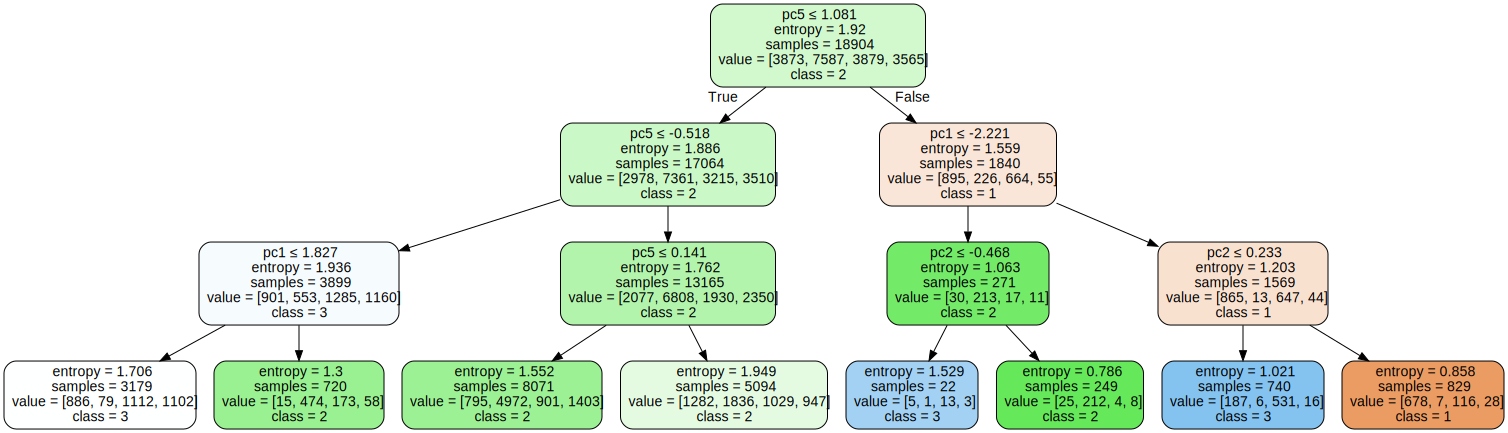

In [58]:
#from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_grid_bal.best_estimator_, out_file=None, 
                                feature_names=X_train.columns,
                                class_names=['1','2','3','4'], 
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

### Building Random Forests

In [59]:
clf_rf = RandomForestClassifier()

In [60]:
clf_rf.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

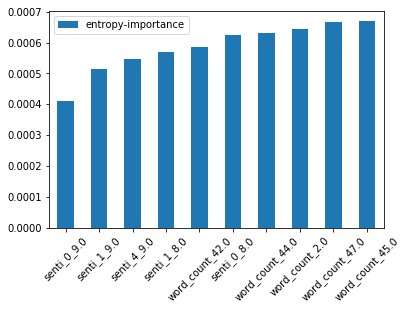

In [61]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, clf_rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'entropy-importance'})
importances.sort_values(by='entropy-importance')[:10].plot(kind='bar', rot=45)

### XGB without SMOTE

In [62]:
%%time

clf_XGB_nsm = XGBClassifier(random_state=123, n_jobs=-1)

param_grid_XGB = {'classifier__colsample_bytree':[0.5],
                  'classifier__n_estimators':[500],
                  'classifier__max_depth':[6],
                  'classifier__learning_rate':[0.1],
                  'classifier__subsample':[1]
                 } 

grid_XGB_nsm = GridSearchCV(clf_XGB_nsm, param_grid=param_grid_XGB, cv=5)

grid_XGB_nsm.fit(X_train,Y_train)

CPU times: user 2min 53s, sys: 712 ms, total: 2min 54s
Wall time: 44.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     re...da=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'classifier__colsample_bytree': [0.5],
                         'classifier__learning_rate': [0.1],
     

In [63]:
X_train.shape

(18904, 120)

In [64]:
train_pred_xgbnsm = grid_XGB_nsm.predict(X_train)
test_pred_xgbnsm = grid_XGB_nsm.predict(X_test)

#print(confusion_matrix(y_true=Y_train, y_pred = train_pred_logreg))

print(accuracy_score(y_true=Y_train, y_pred=train_pred_xgbnsm))
print(accuracy_score(y_true=Y_test, y_pred=test_pred_xgbnsm))


f1_train_xgbnsm = f1_score(y_true=Y_train, y_pred=train_pred_xgbnsm,average='weighted')
f1_test_xgbnsm = f1_score(y_true=Y_test, y_pred=test_pred_xgbnsm,average='weighted')

print("F1 score for XGB model is ",f1_train_xgbnsm)
print("F1 score for XGB model is ",f1_test_xgbnsm)

0.6790626322471435
0.6625524561836583
F1 score for XGB model is  0.6564811199861309
F1 score for XGB model is  0.637235384776018


### Building SVM

In [65]:
from sklearn.svm import SVC

In [66]:
%%time

clf_svm = SVC(random_state=123)

param_grid_svm = {'C':[10,100,500],
                  'kernel':['rbf']
                 } 

grid_XGB_svm = GridSearchCV(clf_svm, param_grid=param_grid_svm, cv=5)

grid_XGB_svm.fit(X_train,Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

CPU times: user 20min 56s, sys: 11.2 s, total: 21min 7s
Wall time: 21min 7s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [10, 100, 500], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [67]:
grid_XGB_svm.best_params_


{'C': 100, 'kernel': 'rbf'}

In [68]:
train_pred_svm = grid_XGB_svm.predict(X_train)
test_pred_svm = grid_XGB_svm.predict(X_test)

#print(confusion_matrix(y_true=Y_train, y_pred = train_pred_logreg))

print(accuracy_score(y_true=Y_train, y_pred=train_pred_svm))
print(accuracy_score(y_true=Y_test, y_pred=test_pred_svm))


f1_train_svm = f1_score(y_true=Y_train, y_pred=train_pred_svm,average='weighted')
f1_test_svm = f1_score(y_true=Y_test, y_pred=test_pred_svm,average='weighted')

print("F1 score for SVM model is ",f1_train_svm)
print("F1 score for SVM model is ",f1_test_svm)

0.671868387642827
0.6289804986423105
F1 score for SVM model is  0.648518829426713
F1 score for SVM model is  0.5957247292792748


## Loading and Pre-Processing the test data

In [72]:
test_final = pd.read_csv(url8,na_values=[' '],index_col=[0])

In [73]:
#test_final.isna().sum()
test_final.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,Senti_blob,senti_train,tweeted_day_of_week,tweet_month
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,0.0,0.0,1.0,0.0,1.0,5.0,neutral,2.0,Saturday,July
1,270008,2018-05-10,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,May
2,270009,2018-01-10,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,January
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,0.0,0.0,1.0,1.0,0.0,15.0,neutral,2.0,Wednesday,October
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,0.0,0.0,1.0,0.0,2.0,8.0,neutral,2.0,Friday,July


In [74]:
test_final['date'] = pd.to_datetime(test_final['date']).dt.date

test_final.head(2)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,Senti_blob,senti_train,tweeted_day_of_week,tweet_month
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,0.0,0.0,1.0,0.0,1.0,5.0,neutral,2.0,Saturday,July
1,270008,2018-05-10,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,May


In [75]:
#test_final['alpha'] = grid_XGB_nsm.predict(test_final)

In [76]:
test_final.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,senti_0,senti_1,senti_2,senti_3,senti_4,word_count,Senti_blob,senti_train,tweeted_day_of_week,tweet_month
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,0.0,0.0,1.0,0.0,1.0,5.0,neutral,2.0,Saturday,July
1,270008,2018-05-10,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,May
2,270009,2018-01-10,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,January
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,0.0,0.0,1.0,1.0,0.0,15.0,neutral,2.0,Wednesday,October
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,0.0,0.0,1.0,0.0,2.0,8.0,neutral,2.0,Friday,July


In [77]:
principalComponents1 = pca.fit_transform(test_final[['SF1','SF2','SF3','SF4','SF5','SF6','SF7']])

In [78]:
principalDf2 = pd.DataFrame(data = principalComponents1
             , columns = ['pc1','pc2','pc3','pc4','pc5'])

In [79]:
test_final = test_final.drop(['SF1','SF2','SF3','SF4','SF5','SF6','SF7'],axis=1)


In [80]:
test_final = pd.concat([principalDf2, test_final], axis = 1)


In [ ]:
test_final['alpha'] = grid_XGB_nsm.predict(test_final)
test_final[['Id','alpha']].to_csv('sub_final4.csv',index=False)